In [1]:
# ! pip install --upgrade opencv-python

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import pathlib
import matplotlib
from datetime import datetime
import cv2
import matplotlib.pyplot as plt
from scipy import misc
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from scipy.ndimage import morphology, filters

#converts rgb to gray
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

#labels image by checking connected objects
def border(im,labels,label):
    N,L = im.shape
    b = zeros_like(im)
    for i in range(0,N):
        for j in range(0,L):
            if (labels[i,j]==label):
                b[i,j]=1
    return np.array(b)

#returns the label index of the biggest object
def biggestCC_index(labels):
    index=1
    max_area=0
    max_index=1
    for region in regionprops(labels):
        if region.area > max_area:
            max_area=region.area
            max_index=index
        index +=1
    return max_index

#rgb thresholding
def R1(r,g,b):
    e1 = r>55 and g>15 and b>13 and (abs(r-g)>35) and r>g and r>b
    e2 = r>220 and g>210 and b>170 and (abs(r-g)<=15) and r>b and g>b
    return e1

#ycbcr thresholding
def R2(y,cb,cr):
    e3 = cr <= (1.5862*cb)+20;
    e4 = cr >= (0.3448*cb)+76.2069;
    e5 = cr >= (-4.5652*cb)+234.5652;
    e6 = cr <= (-1.15*cb)+301.75;
    e7 = cr <= (-2.2857*cb)+432.85;
    return e3 and e4 and e5 and e6 and e7;

#hsv thresholding
def R3(h,s,v):
    return h<25 or h > 230

#granulation detection
def granulation(img):
    # Convert image to hsv color space
    saturated = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Filter image for different interval of colors
    lower = np.array([0, 230, 90])
    upper = np.array([20, 255, 200])
    skinMask1 = cv2.inRange(saturated, lower, upper)
    
    lower = np.array([160,150,130])
    upper = np.array([185,255,210])
    skinMask2 = cv2.inRange(saturated, lower, upper)
    
    skinMask = cv2.bitwise_or(skinMask1,skinMask2)
    #skinMask = cv2.bitwise_or(skinMask1,skinMask2)
    # Perform an opening in the mask, to remove isolated structures
    Smask = 2
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (Smask,Smask))
    skinMask = cv2.erode(skinMask, kernel, iterations = 2)
    Smask = 20
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (Smask,Smask))
    skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
    return skinMask

    # Apply mask to image
    img = cv2.bitwise_and(img, img, mask = skinMask)

    # Return value channel of image
    return img[:,:,2]

#fibrin detection
def fibrin(img) :
    converted = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    
    lower = np.array([20, 100, 50])
    upper = np.array([140, 220, 170])
    skinMask = cv2.inRange(converted, lower, upper)

    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
    skinMaskaux = cv2.erode(skinMask, kernel, iterations = 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    skinMask = cv2.dilate(skinMaskaux, kernel, iterations = 3)
    
    img = cv2.bitwise_and(img, img, mask = skinMask)

    # Return value channel of image
    return img[:,:,2]

#necrose detection
def necrose(img) :
    
    converted = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower = np.array([0, 30, 10])
    upper = np.array([80, 80, 50])
    skinMask = cv2.inRange(converted, lower, upper)
    imshow(skinMask)
    figure()
    # Apply mask to image
    img = cv2.bitwise_and(img, img, mask = skinMask)
    # Return value channel of image
    return img[:,:,2]
    

#percentages of fungus and skin as well as image processing
def process(skin,mask_n,mask_f,mask_g):
    
    skin[mask_g!=0] = [255,0,0]
    skin[mask_f!=0] = [255,255,0]
    skin[mask_n!=0] = [0,0,0]
    
    #percentage of each fungus
    total_g = count_nonzero(mask_g)
    total_f = count_nonzero(mask_f)
    total_n = count_nonzero(mask_n)
    total = count_nonzero(skin)
    
    
    return skin,total_n,total_f,total_g,total


#detect percentage of each fungus
def fungus_detection(image):
    #necrosis detection
    n = necrose(image)
    #fibrin detection
    f = fibrin (image)
    #granulation detection
    g = granulation(image)
    return n,f,g
    
#image processing
def segment_skin(frame):
    N,L,T = frame.shape
    print(frame.shape)
    frame = np.array(frame,dtype="uint8")
    mask=zeros_like(frame)
    mask_rgb = zeros_like(frame)
    mask_ycbcr = zeros_like(frame)
    mask_hsv = zeros_like(frame)
    
    bgr = np.array(frame)
    ycbcr = cv2.cvtColor(bgr, cv2.COLOR_RGB2YCR_CB)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_RGB2HSV)
    #rgb
    for i in range(0,N):
        for j in range(0,L):
            pixel_val=bgr[i,j]
            #rgb
            #print(i,j)
            r = int(pixel_val[0])
            g = int(pixel_val[1])
            b = int(pixel_val[2])
            bool_r1=R1(r,g,b)
            if (bool_r1 == 1):
                mask_rgb[i,j]=255
                
    return mask_rgb          

#main function
def main():
    #UI
    #drive_path = input ("Database path: ")
    #image_name = input ("Image name(ie IMG_0143.jpg): ")
    #path= drive_path+"\\"+image_name
    
    #image read
    image_brg = cv2.imread("./images/20230301_111341.jpg")
    image_rgb = image_brg[...,::-1]
    
    #skin thresholding
    mask = segment_skin(image_rgb)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE,kernel,iterations=1)
    
    imsave("./results/mask.jpeg",mask)
    
    #hole filling
    mask = morphology.binary_fill_holes(mask[:,:,1])
    
    #image labeling by object size
    labels = label(mask)
    max_index = biggestCC_index(labels)
    
    mask=border(mask,labels,max_index)
    
    imsave("./results/mask.jpeg",mask)
    
    #desired skin for each channel R, G and B
    skin = zeros_like(image_rgb)
    bord = image_rgb
    for i in range(0,3):
        skin[:,:,i] = mask * image_rgb[:,:,i]
        bord[:,:,i] = image_rgb[:,:,i] * (mask == 0)
    
    imsave("./results/skin.jpg", skin)
    
    skin_bgr = skin[...,::-1]
    
    #fungus detection masks
    necrosis,fibrin,granulation = fungus_detection(skin_bgr) 
    
    #process image
    final,total_n,total_f,total_g,total = process(skin,necrosis,fibrin,granulation)
    segmented = bord + final
    
    print(total_n,total_f,total_g)
    
    #write
    h,w,t=skin.shape
    n = "Percentage of necrosis: " + str(round((total_n/total)*100,2)) + "%"
    f = "Percentage of fibrin: " + str(round((total_f/total)*100,2)) + "%"
    g = "Percentage of granulation: " + str(round((total_g/total)*100,2)) + "%"
    
    # add the text to the images
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (0,0,0)
    cv2.putText(segmented,g,(50,h - 100), font, 3,color,10,cv2.LINE_AA)
    cv2.putText(segmented,f,(50, h - 200), font, 3,color,10,cv2.LINE_AA)
    cv2.putText(segmented,n,(50, h - 300), font, 3,color,10,cv2.LINE_AA)

    #segmented image + original
    imshow(segmented)
    figure()
    imsave("./results/final.jpg", segmented)



(4032, 1816, 3)
1233 0 32220


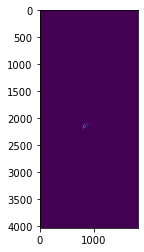

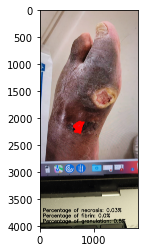

<Figure size 432x288 with 0 Axes>

In [4]:
main()